In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import os

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Data preparation

### Hyperparameters

In [8]:
BEST_PATH = './models/best_AE_BiLSTM.h5'
LEARNING_RATE = 0.001
BATCH_SIZE = 8

### data loading

In [9]:
l = np.load('./env_set/dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [10]:
print(train_input.shape)
print(train_label.shape)
print()
print(test_input.shape)
print(test_label.shape)

(41025, 24, 5)
(41025, 24, 5)

(16119, 24, 5)
(16119, 24, 5)


In [11]:
trainset = np.concatenate([train_input, train_label], axis=0).astype(np.float32)
testset = np.concatenate([test_input, test_label], axis=0).astype(np.float32)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
class RetrainLayer(tf.keras.layers.Layer):
    def __init__(self, num_hidden, activation=tf.nn.relu):
        super(RetrainLayer, self).__init__()
        self.num_hidden = num_hidden
        
        self.dense = tf.keras.layers.Dense(self.num_hidden, activation=activation, kernel_initializer='he_uniform')
        
    def call(self, inp):
        return self.dense(inp)

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, encoding_size):
        super(Encoder, self).__init__()
        
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
        self.output_layer = tf.keras.layers.Dense(self.encoding_size, activation=tf.nn.sigmoid)
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return self.output_layer(inp)        

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, original_size):
        super(Decoder, self).__init__()
        
        self.num_hiddens = num_hiddens[::-1]
        self.original_size = original_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return inp

In [16]:
class Autoencoder(tf.keras.Model):
    def __init__(self, num_hiddens, encoding_size, original_size):
        super(Autoencoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        self.original_size = original_size
        
        self.in_retrain_layer = RetrainLayer(self.num_hiddens[0])
        self.encoder = Encoder(self.num_hiddens, self.encoding_size)
        self.decoder = Decoder(self.num_hiddens, self.original_size)
        self.out_retrain_layer = RetrainLayer(self.original_size, activation = tf.nn.sigmoid)
        
    def call(self, inp, need_code=False, decoding=None):
        inp = self.in_retrain_layer(inp)
        encoded_values = self.encoder(inp)
        if decoding is not None:
            decoding = self.decoder(decoding)
            return self.out_retrain_layer(decoding)
        if not need_code:
            encoded_values = self.decoder(encoded_values)
            return self.out_retrain_layer(encoded_values)
        else:
            return encoded_values

In [17]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [18]:
@tf.function
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [19]:
num_hiddens = [32, 16]
encoding_size = 8
original_size = 5
autoencoder = Autoencoder(num_hiddens, encoding_size, original_size)
opt = tf.optimizers.Adam(learning_rate=0.001)

In [20]:
autoencoder.load_weights('./checkpoints/trained_AE')

In [21]:
encoded_train_input = []
encoded_train_label = []
for step, (inp, tar) in enumerate(train_dataset):
    encoded_train_input.append(autoencoder(inp, True))
    encoded_train_label.append(autoencoder(tar, True))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
encoded_test_input = []
encoded_test_label = []
for step, (inp, tar) in enumerate(test_dataset):
    encoded_test_input.append(autoencoder(inp, True))
    encoded_test_label.append(autoencoder(tar, True))

In [23]:
encoded_train_input = tf.concat(encoded_train_input, axis=0)
encoded_train_label = tf.concat(encoded_train_label, axis=0)
encoded_test_input = tf.concat(encoded_test_input, axis=0)
encoded_test_label = tf.concat(encoded_test_label, axis=0)

In [24]:
print(encoded_train_input.shape)
print(encoded_train_label.shape)
print()
print(encoded_test_input.shape)
print(encoded_test_label.shape)

(41025, 24, 8)
(41025, 24, 8)

(16119, 24, 8)
(16119, 24, 8)


In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((encoded_train_input, encoded_train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((encoded_test_input, encoded_test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [26]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True),
                                  input_shape=[TIME_STEPS, encoding_size]),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(encoding_size)
])

In [27]:
# lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True),
#                                   input_shape=[TIME_STEPS, encoding_size]),
#     tf.keras.layers.LayerNormalization(),
#     tf.keras.layers.Dense(encoding_size)
# ])

In [28]:
# lstm_model = tf.keras.models.load_model(BEST_PATH)

In [29]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 24, 512)           542720    
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 512)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 512)           1574912   
_________________________________________________________________
layer_normalization_1 (Layer (None, 24, 512)           1024      
_________________________________________________________________
dense_7 (Dense)              (None, 24, 8)             4104      
Total params: 2,123,784
Trainable params: 2,123,784
Non-trainable params: 0
_________________________________________________________________


In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=BEST_PATH,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=50)
]

In [31]:
lstm_model.fit(
    train_dataset, epochs = 500,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/500
142/144 [============================>.] - ETA: 0s - loss: 0.3063
Epoch 00001: val_loss improved from inf to 0.00224, saving model to ./models/best_AE_BiLSTM.h5
144/144 [==============================] - 12s 80ms/step - loss: 0.3020 - val_loss: 0.0022
Epoch 2/500
142/144 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00002: val_loss improved from 0.00224 to 0.00157, saving model to ./models/best_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/500
142/144 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00003: val_loss improved from 0.00157 to 0.00134, saving model to ./models/best_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/500
142/144 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss did not improve from 0.00134
144/144 [=====================

In [32]:
test_loss = lstm_model.evaluate(test_dataset, steps=150)

print('Test Loss: {}'.format(test_loss))
#print('Test Accuracy: {}'.format(test_acc))

150/150 [==============================] - 1s 10ms/step - loss: 0.0026
Test Loss: 0.002592471312576284


In [33]:
trained_model = tf.keras.models.load_model(BEST_PATH)
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 24, 512)           542720    
_________________________________________________________________
layer_normalization (LayerNo (None, 24, 512)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 512)           1574912   
_________________________________________________________________
layer_normalization_1 (Layer (None, 24, 512)           1024      
_________________________________________________________________
dense_7 (Dense)              (None, 24, 8)             4104      
Total params: 2,123,784
Trainable params: 2,123,784
Non-trainable params: 0
_________________________________________________________________


In [34]:
np.set_printoptions(precision=6, suppress=True)

In [35]:
pred_result = trained_model.predict(test_dataset)

In [36]:
print(pred_result.shape)
print(encoded_test_label.shape)

(16119, 24, 8)
(16119, 24, 8)


In [37]:
r2 = RSquare()
for _ in range(test_label.shape[-1]):
    r2.reset_states()
    print(r2(tf.cast(encoded_test_label[:, :, _].numpy().reshape(-1), tf.float32),
             tf.cast(pred_result[:, :, _].reshape(-1), tf.float32)))

tf.Tensor(0.4552307, shape=(), dtype=float32)
tf.Tensor(0.67380357, shape=(), dtype=float32)
tf.Tensor(0.5551401, shape=(), dtype=float32)
tf.Tensor(0.7209002, shape=(), dtype=float32)
tf.Tensor(0.8668394, shape=(), dtype=float32)


In [38]:
decoded_pred_result = autoencoder(trainset[0:1, :, :], decoding=pred_result)

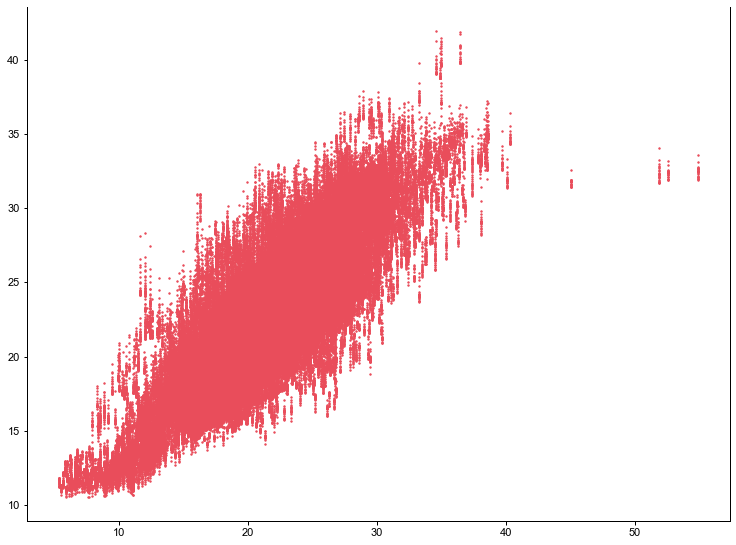

In [39]:
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
#x = np.arange(0,2)
#plt.plot(x, x, 'k')
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*decoded_pred_result + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2
           )
#plt.axis([10,40,10,40])
#plt.plot(x, tf.nn.softmax(logit[0][0, 5, :]).numpy(), c=cmap[0], alpha=0.2)
#plt.plot(x, tf.nn.softmax(logit[0][0, -1, :]).numpy(), c=cmap[3], alpha=0.2)

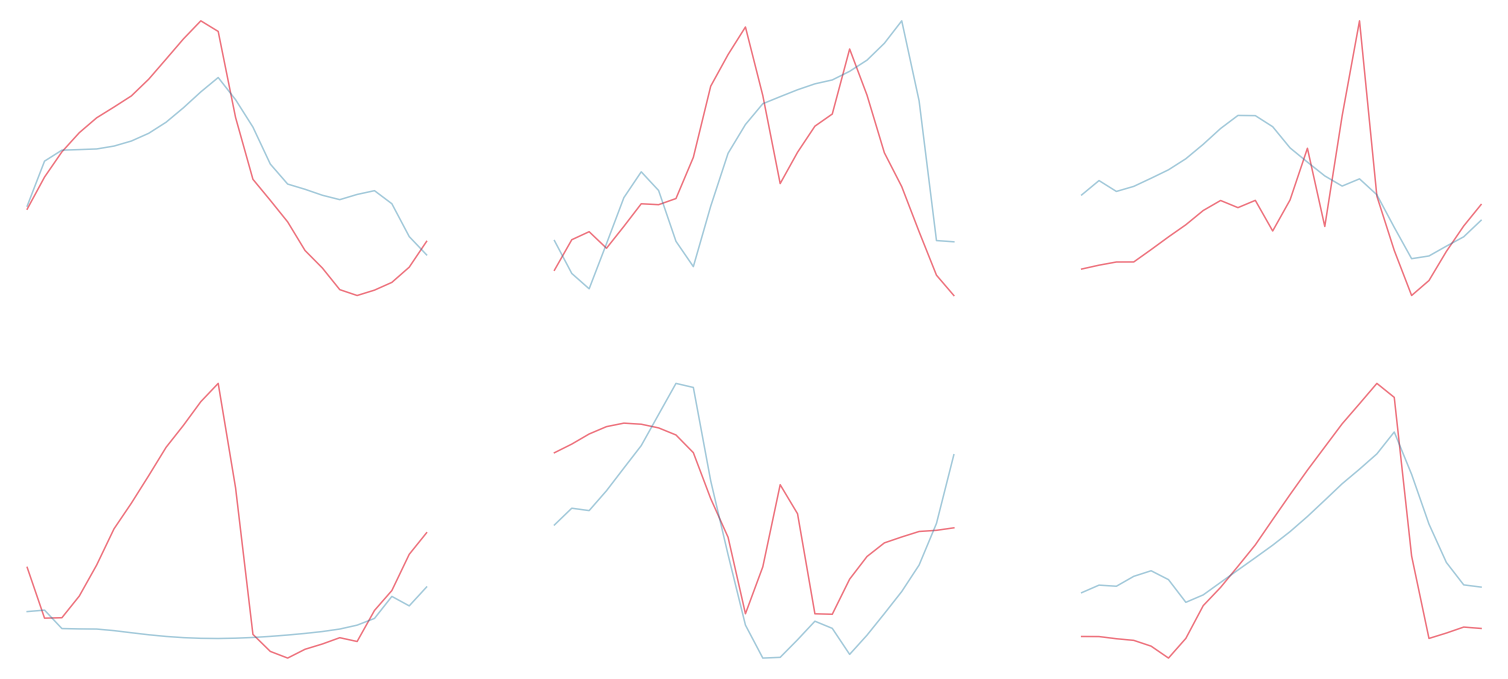

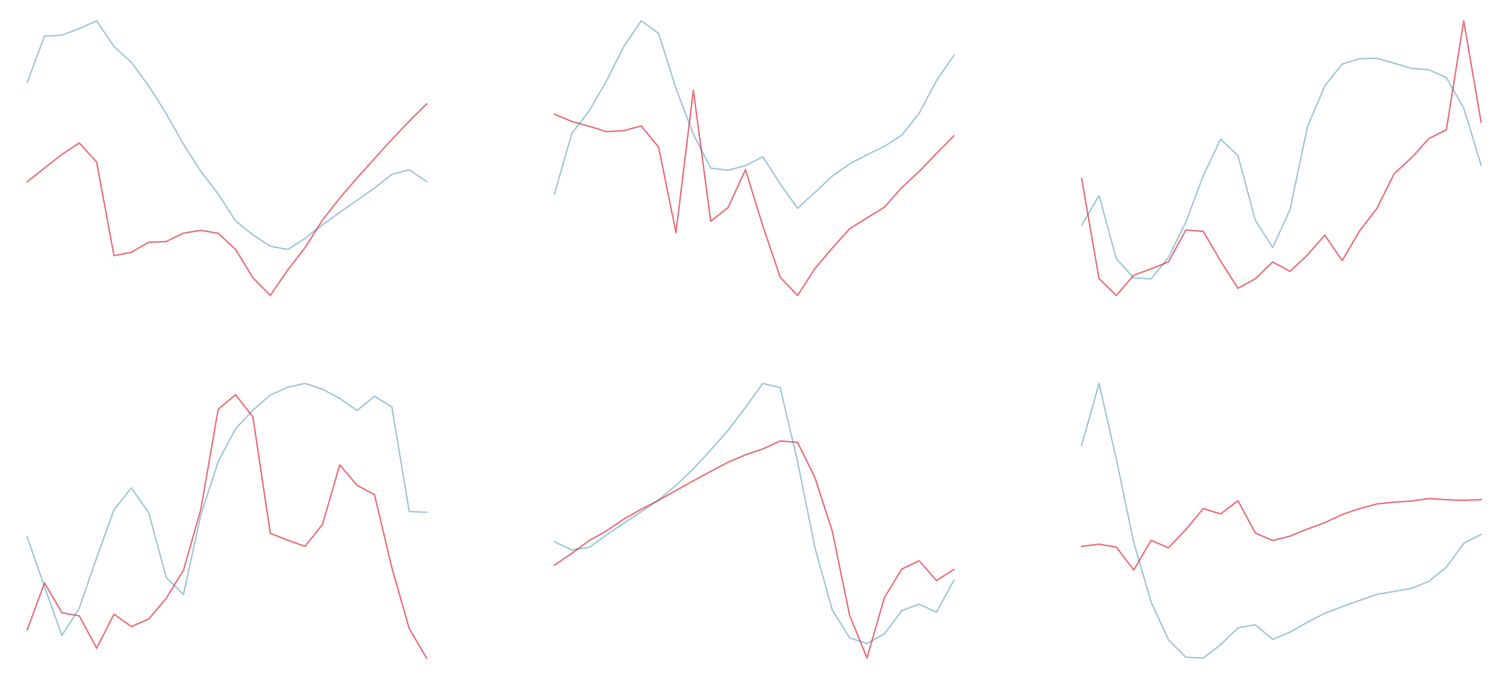

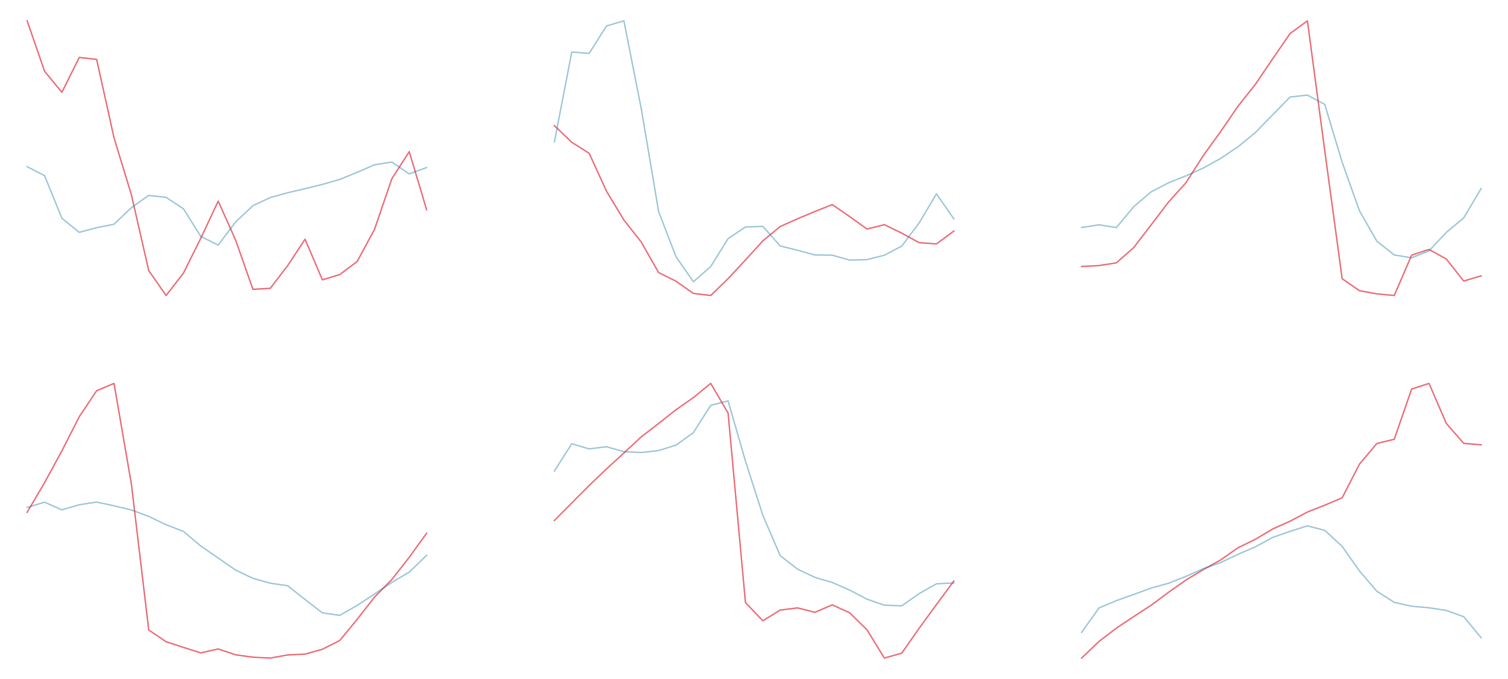

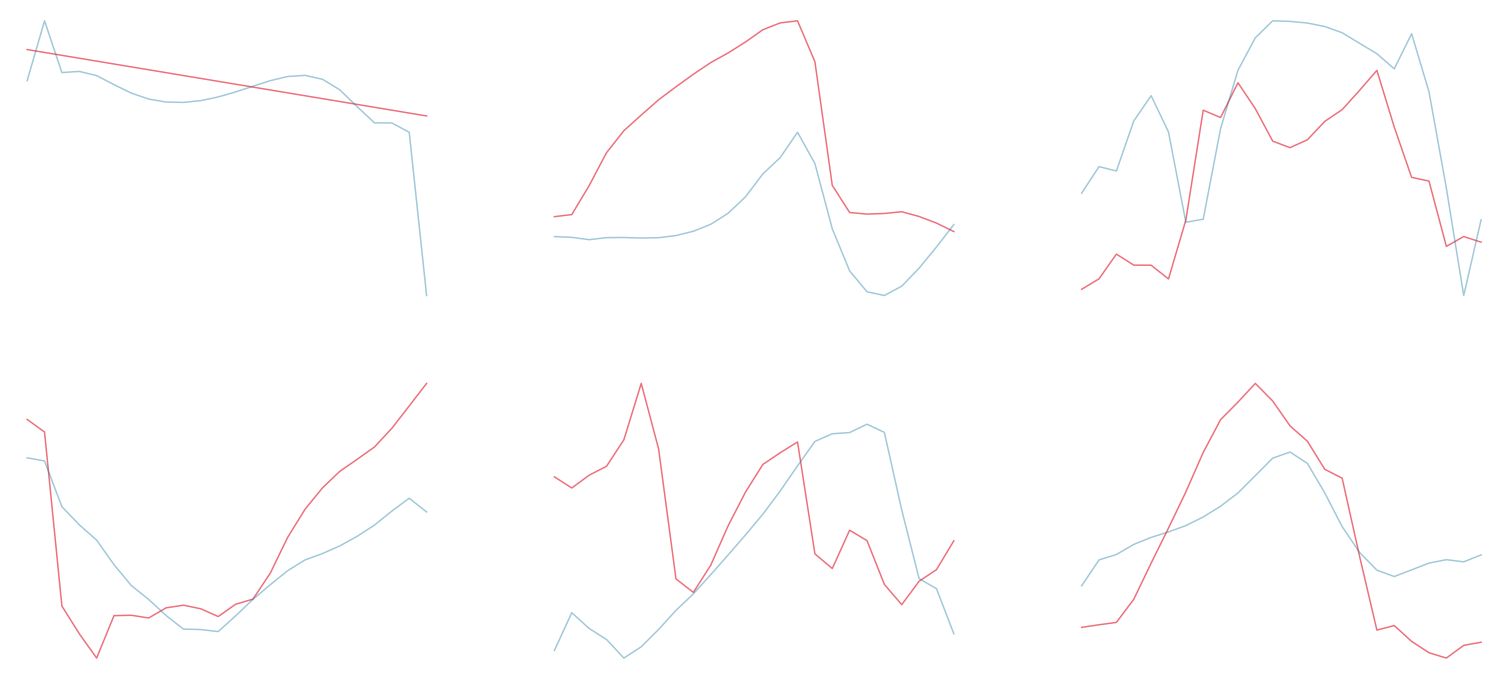

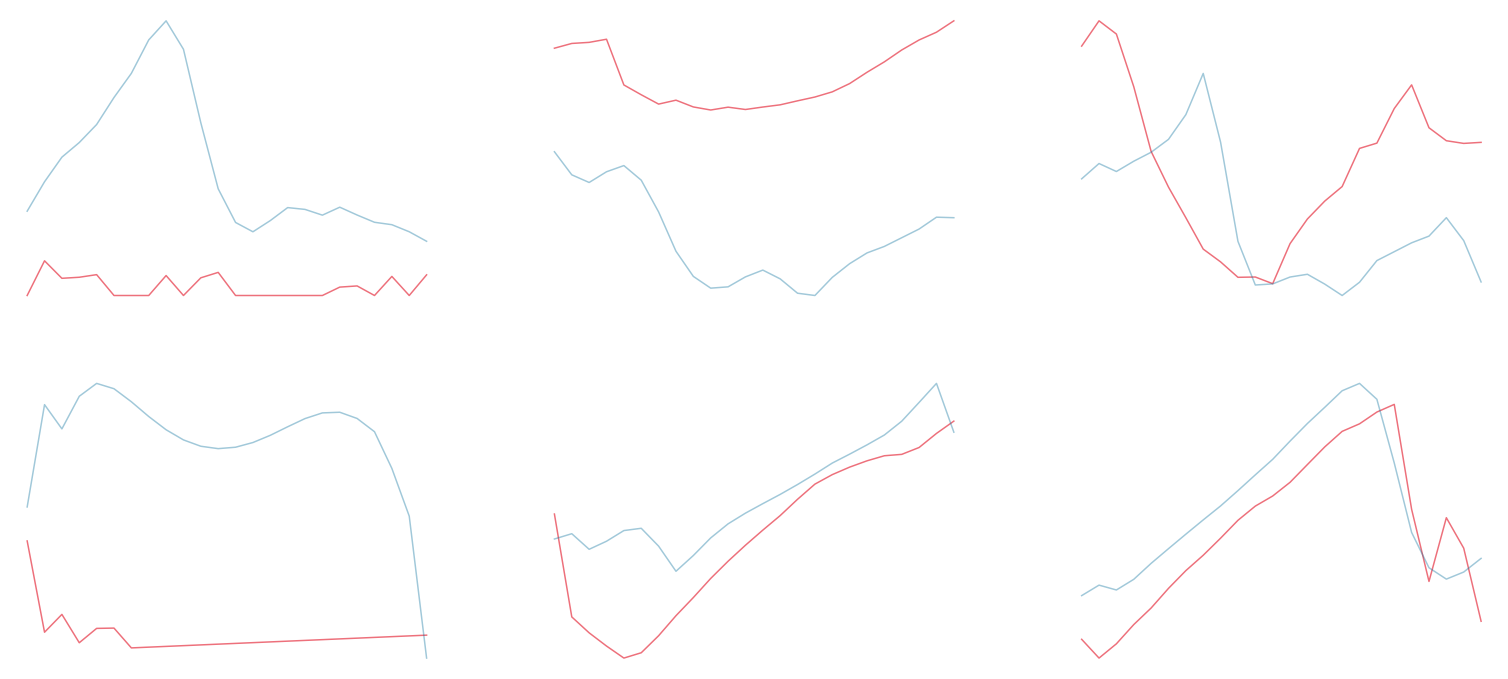

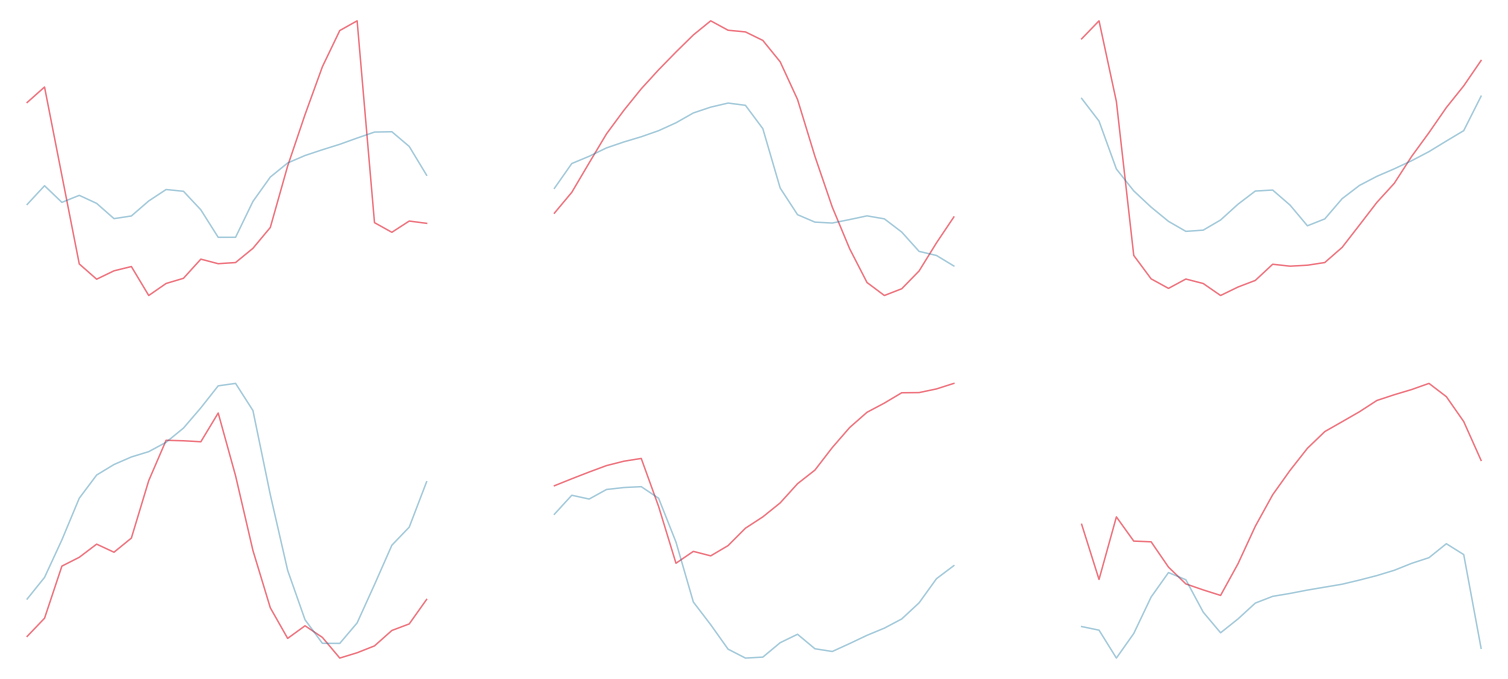

In [40]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=3
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c=cmap[0], alpha=0.8) #measured
            expect1 = plt.plot(x_t, decoded_pred_result[NUMBER, :, i], c=cmap[5], alpha=0.4) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1